In [1]:
import os
os.chdir(os.path.expanduser('~/GPcounts/GPcounts/demo_notebooks'))
import pandas as pd
import numpy as np
import scipy as sp
import scanpy as sc
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import tensorflow as tf


In [2]:
# Generate Coordinates

height = 50
width = 50

n_locations = height * width
x,y = np.meshgrid(np.arange(height), np.arange(width))
coords = np.column_stack((np.ndarray.flatten(x), np.ndarray.flatten(y)))

coords

array([[ 0,  0],
       [ 1,  0],
       [ 2,  0],
       ...,
       [47, 49],
       [48, 49],
       [49, 49]])

In [3]:
from sklearn.gaussian_process.kernels import RBF

def get_cov_from_rbf(coords: np.array, length_scale: float = 1.0) -> np.array:
    """
    Generate covariance matrix using RBF kernel

    Parameters
    ----------
    coords : np.array
        Spatial coordinates
    length_scale : float, optional
        Length scale, by default 1.0

    Returns
    -------
    np.array
        Covariance matrix
    """

    kernel = RBF(length_scale=length_scale)
    cov = kernel(coords)

    return cov

In [4]:
from numpy.random import default_rng


random_state = 32
rng = default_rng(random_state)

sigma = 3.0
alpha = 0.8

n_svgs = 10
n_non_svgs = 10

# Generate SVGs using RBF Kernel
n_kernels = 1

length_scales = np.linspace(start = 1, stop = 10, num = n_kernels)
cov = np.zeros((n_kernels, n_locations, n_locations))

for i, length_scale in enumerate(length_scales):
        cov[i] = get_cov_from_rbf(coords=coords, length_scale=length_scale)

# Get Random Proportion
svg_exp = np.zeros((n_locations, n_svgs))
for i in range(n_svgs):
    proportion = rng.dirichlet(alpha=1.0 / np.ones(n_kernels))

    _cov = np.zeros((n_locations, n_locations))
    for j in range(n_kernels):
        _cov += np.multiply(cov[j], proportion[j])

    svg_exp[:, i] = rng.multivariate_normal(mean=np.zeros(n_locations), cov=_cov)
    svg_exp[:, i] = np.multiply(svg_exp[:, i], sigma)

In [5]:
noise = np.multiply(rng.standard_normal(size=(n_locations, n_svgs)), sigma)
svg_exp = np.multiply(svg_exp, 1 - alpha) + np.multiply(noise, alpha)
svg_exp

array([[-1.4545432 ,  0.21058594, -8.95109525, ..., -2.22158461,
        -0.38456698,  1.67159931],
       [ 0.12599388,  0.03194399, -0.24438838, ..., -3.23594374,
         0.83868393,  0.302137  ],
       [ 4.23434663,  0.08956023,  2.82046065, ..., -0.85590962,
         1.45773319, -0.56268654],
       ...,
       [-1.67766256,  1.32995839, -2.08426073, ...,  1.06463214,
        -1.23201288, -0.5213026 ],
       [-2.3223958 ,  1.86384787,  1.66170975, ..., -0.78287465,
        -4.15754896, -1.38550824],
       [ 1.14302542,  1.5644625 , -1.10764627, ..., -0.09167522,
         1.51226523,  3.10082158]])

In [6]:
# Generate Non SVG

non_svgs_exp = np.zeros((n_locations, n_non_svgs))
for i in range(n_non_svgs):
    non_svgs_exp[:, i] = np.multiply(rng.standard_normal(n_locations), sigma)

In [7]:
from sklearn.preprocessing import normalize

# Combine SVGs and non-SVGs and convert data to counts
exponents = np.concatenate((svg_exp, non_svgs_exp), axis=1)
exponents = np.exp(exponents)
exponents = normalize(exponents, axis=1, norm="l1")
exponents.shape

(2500, 20)

In [8]:
Dispersion_ranges = [
                   [.01,.1]  # low dispersion range
                  ,[1.,3.] # high dispersion range
                  ]   

#dispersion = np.random.choice(range(len(Dispersion_ranges)))
#alpha = np.random.uniform(Dispersion_ranges[dispersion][0],Dispersion_ranges[dispersion][1],1)

r = sigma
scaled_exponents = exponents * 10000
scaled_exponents

array([[7.15280496e+00, 3.78122729e+01, 3.96976864e-03, ...,
        3.46873873e+02, 1.24002049e+02, 7.49458209e+01],
       [4.36879903e+01, 3.97664407e+01, 3.01652617e+01, ...,
        9.14406865e+00, 2.33413606e+01, 3.03912316e+01],
       [8.45449610e+02, 1.33976882e+01, 2.05610291e+02, ...,
        1.07830021e+01, 2.90889839e+01, 2.96116220e+01],
       ...,
       [7.79065157e+00, 1.57676496e+02, 5.18788615e+00, ...,
        5.02596683e+01, 3.10304572e+01, 1.43810042e+02],
       [1.95678878e+00, 1.28708276e+02, 1.05152355e+02, ...,
        5.89085173e+00, 7.68433340e+00, 1.48028363e+02],
       [4.93390419e+01, 7.52001163e+01, 5.19680498e+00, ...,
        2.08760224e+02, 3.30648926e+00, 3.35364193e+01]])

In [9]:
from scipy.stats import nbinom
scaled_exponents = rng.negative_binomial(r, r/(r+(scaled_exponents)))
counts = scaled_exponents

In [10]:
import scipy as sp
from anndata import AnnData

is_de_genes = [False] * (n_svgs + n_non_svgs)
for i in range(n_svgs):
    is_de_genes[i] = True

var_ids = [f"gene_{i}" for i in range(n_svgs + n_non_svgs)]
# svg_ids = [f"svg_{i}" for i in range(n_svgs)]
# non_svg_ids = [f"non_svg_{i}" for i in range(n_svgs)]
# var_ids = svg_ids + non_svg_ids

obs_ids = [f"loc_{i}" for i in range(height * width)]

var = pd.DataFrame(data={"spatially_variable": is_de_genes}, index=var_ids)
obs = pd.DataFrame(data={"obs_ids": obs_ids}, index=obs_ids)

counts = sp.sparse.csr_matrix(counts)
adata = AnnData(
    counts, obs=obs, var=var, obsm={"spatial": coords}, dtype=np.float32
)



c:\Users\User\GPcounts\.venv\lib\site-packages\anndata\_core\anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [11]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [12]:
Y = pd.DataFrame(data=adata.X.todense().astype(int).copy(), 
                    index=adata.obs_names, 
                    columns=adata.var_names)

spatial_locations = pd.DataFrame(data=adata.obsm['spatial'], 
                                    index=adata.obs_names, 
                                    columns=['x', 'y'])
spatial_locations['total_counts'] = adata.X.sum(axis=1)

scales = []
for i in range(0, len(Y.columns)):
    model=smf.glm(formula = "Y.iloc[:, i]~0+spatial_locations['total_counts']", 
                    data=Y, 
                    family=sm.families.NegativeBinomial(sm.families.links.identity())).fit()
    res = model.params[0]*spatial_locations['total_counts']
    scales.append(res)

scalesdf=pd.DataFrame(scales)
scalesdf=scalesdf.T

Y = Y.T
X = spatial_locations[['x', 'y']]

c:\Users\User\GPcounts\.venv\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Users\User\GPcounts\.venv\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
c:\Users\User\GPcounts\.venv\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\User\AppData\Local\Temp\ipykernel_1872\1680011604.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

In [13]:
Y

,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,...,loc_2490,loc_2491,loc_2492,loc_2493,loc_2494,loc_2495,loc_2496,loc_2497,loc_2498,loc_2499
gene_0,1,3,6,1,3,5,6,4,6,1,...,2,6,2,2,4,0,1,3,1,3
gene_1,4,4,3,1,3,2,0,0,6,6,...,4,3,3,1,7,5,1,5,4,4
gene_2,0,2,5,7,8,4,5,0,3,1,...,3,6,1,3,3,1,0,0,4,1
gene_3,7,8,0,4,6,1,0,4,4,5,...,4,6,1,3,1,6,2,1,0,0
gene_4,1,2,1,5,3,2,8,4,6,7,...,2,5,1,4,3,0,4,1,6,0
gene_5,0,4,2,2,5,4,3,0,0,5,...,4,4,3,3,1,6,0,2,8,4
gene_6,8,2,0,4,0,6,5,2,5,7,...,5,7,6,0,0,8,2,4,5,2
gene_7,1,0,2,5,4,4,4,0,4,0,...,6,5,4,1,0,5,4,5,2,3
gene_8,2,4,4,6,6,0,5,9,8,4,...,6,3,3,4,3,2,5,2,0,5
gene_9,4,3,2,1,6,5,2,1,4,7,...,3,5,1,1,2,1,4,4,0,6


<BarContainer object of 10 artists>

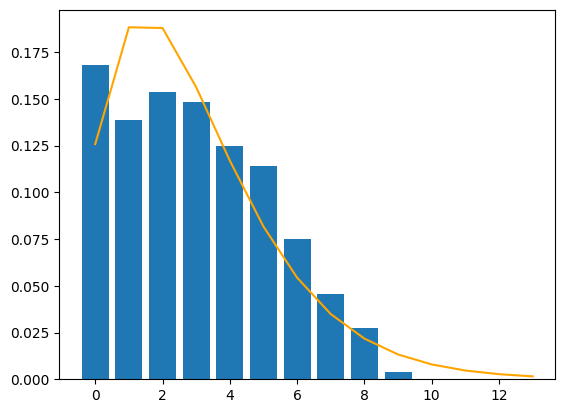

In [14]:
from scipy.stats import poisson, nbinom


y = Y.iloc[0]
test = dict(y.value_counts().sort_index() / len (y))
vals = list(test.values())
keys = list(test.keys())
ys = np.arange(0, np.max(keys)+5)

mean = np.mean(y)

fit = nbinom.pmf(ys, r, r/(mean + r))

plt.plot(fit, color="orange")
plt.bar(keys, vals)

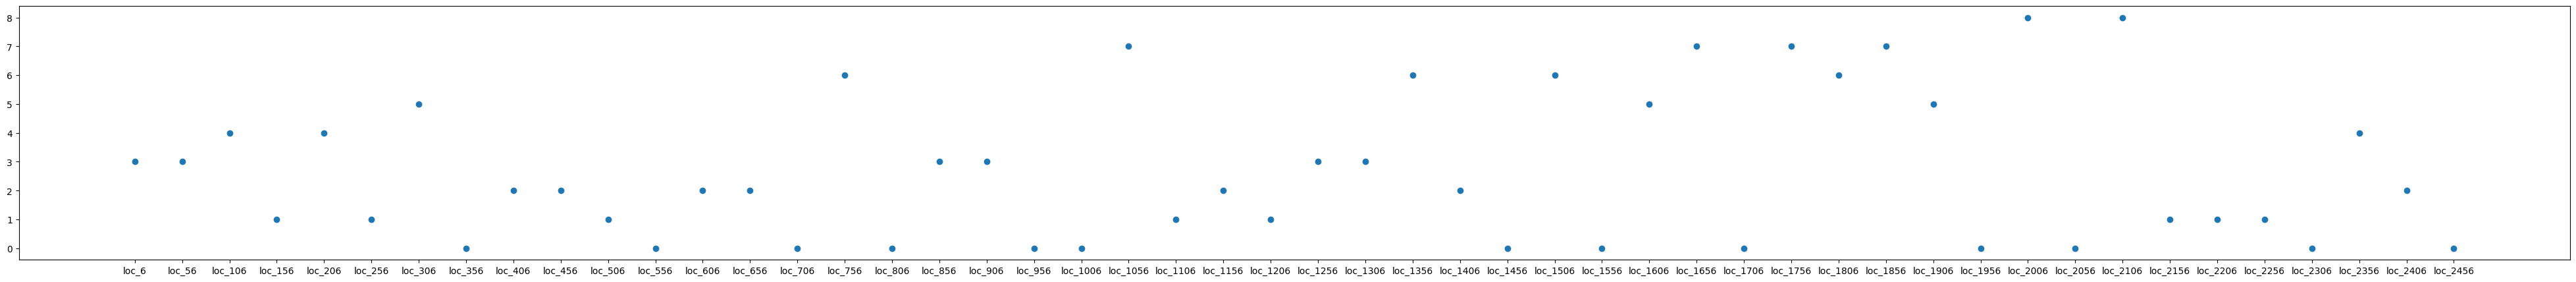

In [15]:

plt.figure(figsize=(50,5))
test = list(X[X.x == 30].index)
ys = Y[test]
y = ys.iloc[0]
plt.scatter(X[X.x == 6].index, y)

In [16]:
os.chdir(os.path.expanduser('~/GPcounts/GPcounts/'))
from GPcounts.RNA_seq_GP import rna_seq_gp

gene_name = Y.index
gpc1 = rna_seq_gp(X, Y, True, safe_mode=False, scale=scalesdf)
llr1 = gpc1.One_sample_test(kernel_type ="Nugget")
r1 = gpc1.calculate_FDR(llr1)

r1 = r1.assign(spatially_variable=np.select([r1.q_value<=0.05, r1.q_value > 0.05], [1, 0]))




local


  0%|          | 0/20 [00:00<?, ?it/s]

init var = 0.38467489639104
init var = 0.38467489639104
Nugget: alpha = 0.29860028826147117


  5%|▌         | 1/20 [00:09<02:55,  9.24s/it]

Constant: alpha = 0.31342902002556394
init var = 0.3952508622733409
init var = 0.3952508622733409
Nugget: alpha = 0.3494702273668288


 10%|█         | 2/20 [00:14<02:09,  7.18s/it]

Constant: alpha = 0.3542936569021133
init var = 0.4000770888187589
init var = 0.4000770888187589
Nugget: alpha = 0.3448221429995555


 15%|█▌        | 3/20 [00:20<01:47,  6.33s/it]

Constant: alpha = 0.3448375349727778
init var = 0.4096691561842971
init var = 0.4096691561842971
Nugget: alpha = 0.3569845247941766


 20%|██        | 4/20 [00:25<01:36,  6.06s/it]

Constant: alpha = 0.35689434228665656
init var = 0.3854682870558212
init var = 0.3854682870558212
Nugget: alpha = 0.3313919244717025


 25%|██▌       | 5/20 [00:32<01:31,  6.08s/it]

Constant: alpha = 0.33136597168950616
init var = 0.3821672134385985
init var = 0.3821672134385985
Nugget: alpha = 0.28967400710645225


 30%|███       | 6/20 [00:37<01:19,  5.70s/it]

Constant: alpha = 0.28968909568273604
init var = 0.39791164006209234
init var = 0.39791164006209234
Nugget: alpha = 0.3419811647934936


 35%|███▌      | 7/20 [00:42<01:13,  5.65s/it]

Constant: alpha = 0.34290409079393486
init var = 0.40325169275492834
init var = 0.40325169275492834
Nugget: alpha = 0.3161336223096599


 40%|████      | 8/20 [00:48<01:07,  5.64s/it]

Constant: alpha = 0.3161614730318259
init var = 0.3908676350334123
init var = 0.3908676350334123
Nugget: alpha = 0.2979573810991588


 45%|████▌     | 9/20 [00:53<00:59,  5.40s/it]

Constant: alpha = 0.29803254157363784
init var = 0.3972763802825071
init var = 0.3972763802825071
Nugget: alpha = 0.3362374990990859


 50%|█████     | 10/20 [00:58<00:52,  5.26s/it]

Constant: alpha = 0.33608072169934555
init var = 0.5040831143675382
init var = 0.5040831143675382
Nugget: alpha = 0.5035059799061901


 55%|█████▌    | 11/20 [01:03<00:47,  5.32s/it]

Constant: alpha = 0.5035121434286838
init var = 0.5024715493481727
init var = 0.5024715493481727
Nugget: alpha = 0.4890251368975935


 60%|██████    | 12/20 [01:08<00:41,  5.21s/it]

Constant: alpha = 0.48909873670155574
init var = 0.49889378535565165
init var = 0.49889378535565165
Nugget: alpha = 0.5076944075402963


 65%|██████▌   | 13/20 [01:14<00:37,  5.35s/it]

Constant: alpha = 0.5077292343314429
init var = 0.5193635186700556
init var = 0.5193635186700556
Nugget: alpha = 0.505675597875764


 70%|███████   | 14/20 [01:19<00:31,  5.25s/it]

Constant: alpha = 0.5055490067318418
init var = 0.4830163112451601
init var = 0.4830163112451601
Nugget: alpha = 0.4759974405072524


 75%|███████▌  | 15/20 [01:25<00:28,  5.71s/it]

Constant: alpha = 0.4812181978152882
init var = 0.5007156515966813
init var = 0.5007156515966813
Nugget: alpha = 0.46764795064584025


 80%|████████  | 16/20 [01:31<00:22,  5.62s/it]

Constant: alpha = 0.4677277330183258
init var = 0.5013754131620562
init var = 0.5013754131620562
Nugget: alpha = 0.5037156552621455


 85%|████████▌ | 17/20 [01:36<00:16,  5.47s/it]

Constant: alpha = 0.5036947066435858
init var = 0.4985507170808168
init var = 0.4985507170808168
Nugget: alpha = 0.5117263523888224


 90%|█████████ | 18/20 [01:41<00:10,  5.30s/it]

Constant: alpha = 0.5116237981518529
init var = 0.5033219243171172
init var = 0.5033219243171172
Nugget: alpha = 0.49928839114739143


 95%|█████████▌| 19/20 [01:46<00:05,  5.28s/it]

Constant: alpha = 0.4992012821951779
init var = 0.4939221161569405
init var = 0.4939221161569405
Nugget: alpha = 0.46931168491350533


100%|██████████| 20/20 [01:51<00:00,  5.59s/it]

Constant: alpha = 0.46933678135353707



C:\Users\User\GPcounts\GPcounts\GPcounts\RNA_seq_GP.py:415: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


In [17]:
r1

,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,p_value,q_value,spatially_variable
gene_0,-5395.117702,-5403.340075,8.222373,0.000050,0.001002,1
gene_1,-5481.833094,-5483.705420,1.872325,0.052977,0.353179,0
gene_2,-5458.578513,-5458.578503,-0.000010,1.000000,1.000000,0
gene_3,-5401.192619,-5401.192705,0.000086,0.989531,1.000000,0
gene_4,-5480.202724,-5480.202711,-0.000013,1.000000,1.000000,0
gene_5,-5493.561257,-5493.561251,-0.000005,1.000000,1.000000,0
gene_6,-5475.112149,-5475.566535,0.454386,0.340440,1.000000,0
gene_7,-5504.717926,-5504.717915,-0.000011,1.000000,1.000000,0
gene_8,-5473.050939,-5473.050927,-0.000011,1.000000,1.000000,0
gene_9,-5503.039595,-5503.039500,-0.000095,1.000000,1.000000,0
